In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import itertools

In [3]:
load_file_path=os.path.join('/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Baseline Mnist', 'Copy of Baseline Mnist 1*1.csv')
print(load_file_path)

save_folder='/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Baseline Mnist/processed data'

/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Baseline Mnist/Copy of Baseline Mnist 1*1.csv


In [4]:
# Load the CSV file into a dataframe
dataframe = pd.read_csv(load_file_path)

add flops col

In [5]:
def preprocess_dataframe(df, flops_dict):
    # Step 1: Modify column names and remove specific columns
    #df.rename(columns={'conv1x1_3x3.1': 'conv1x1_3x3', 'conv1x1_5x5.1': 'conv1x1_5x5'}, inplace=True)
    #df.drop(columns=['conv1x1_3x3.0', 'conv1x1_5x5.0'], inplace=True)

    # Step 2: Add FLOPS columns
    for col, value in flops_dict.items():
        df[col] = value

    return df

# Example usage:
flops_dict = {"branch1.0FLOPS": 0.012544, "branch2.0FLOPS": 0.012544, "branch3.0FLOPS": 0.012544, "totalFLOPS": 9.674}
df = preprocess_dataframe(dataframe, flops_dict)

normalize layer feature attribution in this stack

In [6]:
def normalize_feature_attribution_final(df):
    """
    Final modification of the normalization of feature attributions for each layer.

    Parameters:
    df (DataFrame): The dataframe containing the feature attributions.

    Returns:
    DataFrame: A modified dataframe with normalized feature attributions for each layer.
    """
    # Columns to be normalized
    layers = ['branch1.0','branch2.0','branch3.0']

    # New sum calculation using specific layers
    df['sum_feature_attr'] = df[layers].sum(axis=1)

    # Normalize each layer by dividing by the new sum of feature attributions
    for layer in layers:
        df[f'norm_{layer}'] = df[layer] / df['sum_feature_attr']

    df.drop(['sum_feature_attr','branch1.0','branch2.0','branch3.0'], axis=1, inplace=True)

    return df

# Example usage of the final modified function
normalized_final_df = normalize_feature_attribution_final(df.copy())

get average and normalzied variance for each combination of hyperparameter

In [7]:
def calculate_normalized_variance(df, method, flops_dict):
    """
    Modified combined function to calculate the average and normalized variance of each layer's feature attribution
    for a given method, including both average and variance in one dataframe, along with average accuracy after each epoch.
    This version also includes FLOPS information.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    method (str): The method to filter the data ('deeplift' or 'integrated_gradients').
    flops_dict (dict): Dictionary containing FLOPS values for different layers.

    Returns:
    DataFrame: A dataframe with the average and normalized variance for each layer combined, and average accuracy after each epoch, including FLOPS info.
    """
    # Filter the dataframe based on the method
    filtered_df = df[df['method'] == method]

    # Columns for which to calculate average and normalized variance, excluding certain layers
    layers = ['norm_branch1.0','norm_branch2.0','norm_branch3.0']
    accuracy_columns = ['train accuracy epoch0', 'test accuracy epoch0']

    # Group by hyperparameters and calculate mean and variance for feature attributions and accuracy
    grouped = filtered_df.groupby(['initial_lr', 'optimizer', 'criterion', 'train_data_used', 'train_set_shuffle', 'train_batch_size'])
    avg_norm = grouped[layers].mean()
    var_norm = grouped[layers].var()
    avg_acc = grouped[accuracy_columns].mean()

    # Calculate normalized variance (variance/mean)
    norm_var = var_norm / avg_norm

    # Combine average and normalized variance into one dataframe
    combined_df = avg_norm.copy()
    for layer in layers:
        combined_df[f'norm_var_{layer}'] = norm_var[layer]

    # Calculate the average normalized variance across the selected layers
    norm_var_layers = [f'norm_var_{layer}' for layer in layers]
    combined_df['avg_normalized_variance'] = combined_df[norm_var_layers].mean(axis=1)

    # Adding average accuracy columns
    for acc_col in accuracy_columns:
        combined_df[acc_col] = avg_acc[acc_col]

    # Add FLOPS information
    for flops_key, flops_value in flops_dict.items():
        combined_df[flops_key] = flops_value

    return combined_df

# Example usage
combined_avg_norm_var_acc_deeplift = calculate_normalized_variance(normalized_final_df, 'deeplift', flops_dict)

In [8]:
combined_avg_norm_var_acc_deeplift.to_csv(save_folder+"/Baseline mnist 1*1 dl.csv")
combined_avg_norm_var_acc_deeplift=pd.read_csv(save_folder+"/Baseline mnist 1*1 dl.csv")

In [9]:
def filter_by_accuracy(df, threshold=70.0):
    """
    Function to filter out rows where the average accuracy across epoch 3 (both train and test) is lower than a specified threshold.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    threshold (float): The threshold for average accuracy in epoch 3.

    Returns:
    DataFrame: A filtered dataframe with rows having average epoch 3 accuracy higher than the threshold.
    """
    # Columns representing epoch 3 accuracy
    epoch_2_accuracy_cols = ['test accuracy epoch0']

    # Calculate the average accuracy for epoch 3
    df['final_test_accuracy'] = df[epoch_2_accuracy_cols].mean(axis=1)

    # Filter the dataframe based on the threshold
    filtered_df = df[df['final_test_accuracy'] >= threshold]

    return filtered_df

# Apply the function to the dataframes for 'deeplift' and 'integrated_gradients'
filtered_deeplift = filter_by_accuracy(combined_avg_norm_var_acc_deeplift)

# Display the first few rows of the filtered dataframes
filtered_deeplift

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,norm_branch1.0,norm_branch2.0,norm_branch3.0,norm_var_norm_branch1.0,norm_var_norm_branch2.0,norm_var_norm_branch3.0,avg_normalized_variance,train accuracy epoch0,test accuracy epoch0,branch1.0FLOPS,branch2.0FLOPS,branch3.0FLOPS,totalFLOPS,final_test_accuracy
0,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.329957,0.339616,0.330427,0.019929,0.009774,0.014631,0.014778,89.272444,92.289333,0.012544,0.012544,0.012544,9.674,92.289333
1,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.322292,0.349365,0.328343,0.015038,0.006837,0.010467,0.010780,87.775444,91.569333,0.012544,0.012544,0.012544,9.674,91.569333
2,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.320723,0.353786,0.325491,0.015259,0.006762,0.011139,0.011053,86.288778,90.948000,0.012544,0.012544,0.012544,9.674,90.948000
3,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.327976,0.340915,0.331109,0.017988,0.009274,0.013791,0.013684,89.071111,93.725333,0.012544,0.012544,0.012544,9.674,93.725333
4,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.321417,0.348076,0.330508,0.015411,0.007233,0.011944,0.011529,87.955111,92.854667,0.012544,0.012544,0.012544,9.674,92.854667
5,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.319585,0.357336,0.323079,0.015337,0.006287,0.009152,0.010259,86.792889,91.886000,0.012544,0.012544,0.012544,9.674,91.886000
6,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.332702,0.328007,0.339292,0.021971,0.013230,0.023336,0.019512,89.981556,93.016667,0.012544,0.012544,0.012544,9.674,93.016667
7,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.335235,0.334482,0.330284,0.019596,0.012037,0.013584,0.015072,88.397556,92.221333,0.012544,0.012544,0.012544,9.674,92.221333
8,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.328495,0.345931,0.325574,0.017713,0.009043,0.011478,0.012745,86.383778,91.462667,0.012544,0.012544,0.012544,9.674,91.462667
9,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.339381,0.320580,0.340039,0.023151,0.018793,0.025481,0.022475,89.909111,94.488667,0.012544,0.012544,0.012544,9.674,94.488667


# Graph

In [10]:
def plot_variance_for_multiple_hyperparam_values(df, hyperparam, variables):
    """
    Plots bar graphs of the average variance of each layer and the overall average variance
    for multiple values of a given hyperparameter.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    hyperparam (str): The hyperparameter to vary.
    variables (list): A list of values for the hyperparameter to compare.

    Returns:
    None: The function plots graphs directly.
    """
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = [col for col in df.columns if 'norm_var' in col]
    variance_columns.append('avg_normalized_variance')

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Average Variance for Different {hyperparam} Values')
    plt.ylabel('Average Variance')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()


In [11]:
filtered_deeplift.to_csv(save_folder+"/Baseline mnist 1*1 dl ave var.csv")

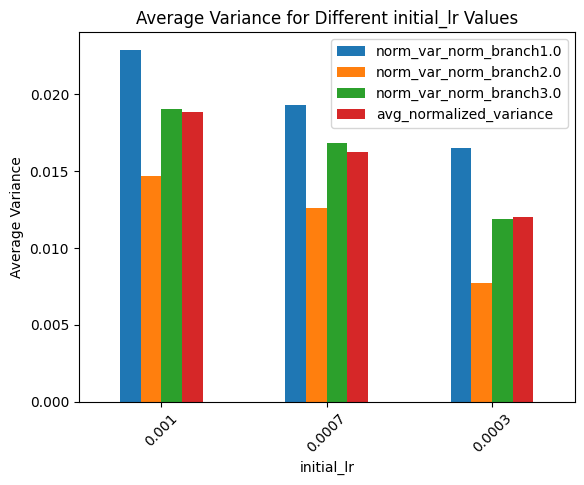

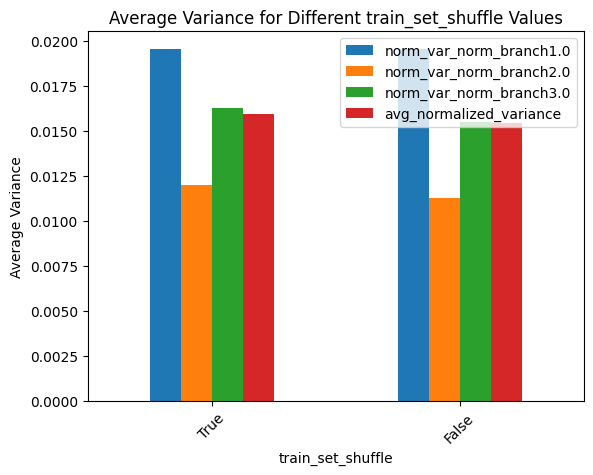

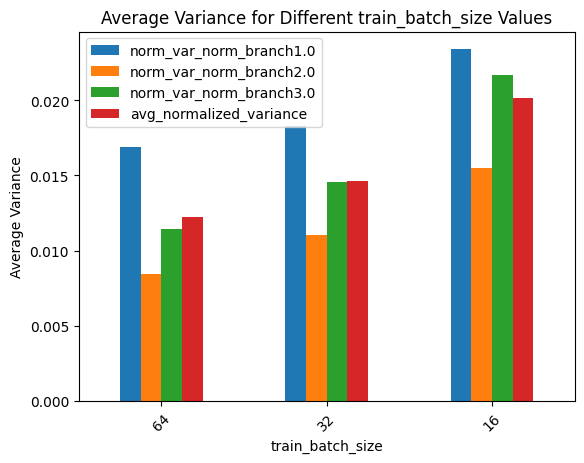

In [12]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_set_shuffle': [True,False],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_variance_for_multiple_hyperparam_values(filtered_deeplift, hyperparam, variables)

# T test

In [13]:
def perform_t_test(df, target_column, condition_column, choice1, choice2):
    # Splitting the data into two groups based on the condition
    group1 = df[df[condition_column] == choice1][target_column]
    group2 = df[df[condition_column] == choice2][target_column]

    # Performing the independent t-test
    t_statistic, p_value = ttest_ind(group1, group2)

    return t_statistic, p_value

initial_lr

In [14]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0007)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 0.9177097049982057 P-value: 0.3803722106426235


In [15]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0003)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 2.7414779372804507 P-value: 0.02077997122708395


In [16]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'initial_lr', 0.0007, 0.0003)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 2.3441143274218574 P-value: 0.04105059202387825


train_set_shuffle

In [17]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_set_shuffle', True, False)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 0.21509693843229238 P-value: 0.8324095248627881


train_batch_size

In [18]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_batch_size', 64, 32)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -1.5267047714315345 P-value: 0.15782196698694312


In [19]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_batch_size', 64, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -3.5474365258903853 P-value: 0.005290788143659822


In [20]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_batch_size', 32, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -2.1377132642201633 P-value: 0.058259108458096016


# Paired T test

In [21]:
def one_sided_paired_ttest(data_set1, data_set2):
    """
    Perform a one-sided paired t-test to determine if the first data set is statistically larger than the second.

    Parameters:
    data_set1 (array-like): The first set of data.
    data_set2 (array-like): The second set of data.

    Returns:
    tuple: A tuple containing the t-statistic and the one-sided p-value.
    """
    t_statistic, p_value = ttest_rel(data_set1, data_set2)

    # Adjust p-value for one-sided test
    if t_statistic > 0:
        p_value_one_sided = p_value / 2
    else:
        p_value_one_sided = 1 - (p_value / 2)

    return t_statistic, p_value_one_sided

# Example usage:
# t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
# print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)


In [22]:
def find_rows_with_fixed_conditions(df, conditions):
    # Filter the DataFrame based on the conditions
    filtered_df = df
    for column, value in conditions.items():
        filtered_df = filtered_df[filtered_df[column] == value]

    return filtered_df

In [23]:
def generate_hyperparameter_combinations(hyperparams):
    """
    Generate a sequence of hyperparameter combinations.

    :param hyperparams: A dictionary where keys are the names of hyperparameters,
                        and values are lists of possible choices for each hyperparameter.
    :return: A list of dictionaries, each representing a unique combination of hyperparameters.
    """
    # Extract the hyperparameter names and their corresponding choices
    keys, values = zip(*hyperparams.items())

    # Generate all possible combinations of hyperparameter values
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    return all_combinations

In [24]:
def get_all_pairs(df, hyperparams_choice_list, target_column, condition_column, choice1, choice2):
    hyperparams_choice_list_compressed = {key: value for key, value in hyperparams_choice_list.items() if key != condition_column}
    all_combinations = generate_hyperparameter_combinations(hyperparams_choice_list_compressed)
    choice1_target_values=[]
    choice2_target_values=[]
    for conditions in all_combinations:
      x = find_rows_with_fixed_conditions(df, conditions)
      try:
        choice1_value = float(x[x[condition_column] == choice1][target_column])
        choice2_value = float(x[x[condition_column] == choice2][target_column])
        print(choice1_value, choice2_value)
      except:
        continue
      choice1_target_values.append(choice1_value)
      choice2_target_values.append(choice2_value)
    return choice1_target_values, choice2_target_values

initial_lr

In [25]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0007)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0143094229186577 0.0123683088086223
0.0207488842871355 0.0150416123228497
0.0230915518183272 0.0224750316534144
0.0128415232355499 0.0127447758639995
0.0146422934831793 0.0150721071989776
0.0274759955519559 0.019512329245714
T-statistic: 1.9016614776968208 One-sided P-value: 0.05780827019373799


In [26]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.0007, 0.0003)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0123683088086223 0.0102587562039702
0.0150416123228497 0.0115292998418979
0.0224750316534144 0.013684319057423
0.0127447758639995 0.011053189843602
0.0150721071989776 0.0107804741176686
0.019512329245714 0.0147781876274127
T-statistic: 4.023852596694517 One-sided P-value: 0.005041142598819074


In [27]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0003)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0143094229186577 0.0102587562039702
0.0207488842871355 0.0115292998418979
0.0230915518183272 0.013684319057423
0.0128415232355499 0.011053189843602
0.0146422934831793 0.0107804741176686
0.0274759955519559 0.0147781876274127
T-statistic: 3.9756863321099547 One-sided P-value: 0.005288033165711078


train_set_shuffle

In [28]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_set_shuffle', True, False)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0143094229186577 0.0128415232355499
0.0207488842871355 0.0146422934831793
0.0230915518183272 0.0274759955519559
0.0123683088086223 0.0127447758639995
0.0150416123228497 0.0150721071989776
0.0224750316534144 0.019512329245714
0.0102587562039702 0.011053189843602
0.0115292998418979 0.0107804741176686
0.013684319057423 0.0147781876274127
T-statistic: 0.5281296533929651 One-sided P-value: 0.30587050634956353


train_batch_size

In [29]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 32, 64)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0207488842871355 0.0143094229186577
0.0146422934831793 0.0128415232355499
0.0150416123228497 0.0123683088086223
0.0150721071989776 0.0127447758639995
0.0115292998418979 0.0102587562039702
0.0107804741176686 0.011053189843602
T-statistic: 2.590770403889993 One-sided P-value: 0.024395662333548503


In [30]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 16, 32)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0230915518183272 0.0207488842871355
0.0274759955519559 0.0146422934831793
0.0224750316534144 0.0150416123228497
0.019512329245714 0.0150721071989776
0.013684319057423 0.0115292998418979
0.0147781876274127 0.0107804741176686
T-statistic: 3.3460971133246384 One-sided P-value: 0.010207898921857056


In [31]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 16, 64)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0230915518183272 0.0143094229186577
0.0274759955519559 0.0128415232355499
0.0224750316534144 0.0123683088086223
0.019512329245714 0.0127447758639995
0.013684319057423 0.0102587562039702
0.0147781876274127 0.011053189843602
T-statistic: 4.571808631010551 One-sided P-value: 0.0029960068601853564


#layer feature attribution rank frequency comparison

In [32]:
normalized_df = normalized_final_df[normalized_final_df['method'] == 'deeplift']
normalized_df_highacc = filter_by_accuracy(normalized_df)
normalized_df_highacc

<ipython-input-9-78e4492ffc89>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['final_test_accuracy'] = df[epoch_2_accuracy_cols].mean(axis=1)


,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,train accuracy epoch0,test accuracy epoch0,method,run,branch1.0FLOPS,branch2.0FLOPS,branch3.0FLOPS,totalFLOPS,norm_branch1.0,norm_branch2.0,norm_branch3.0,final_test_accuracy
0,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,86.755000,92.47,deeplift,0,0.012544,0.012544,0.012544,9.674,0.485521,0.293281,0.221198,92.47
2,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,88.426667,93.42,deeplift,1,0.012544,0.012544,0.012544,9.674,0.341226,0.269298,0.389477,93.42
4,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,88.233333,93.00,deeplift,2,0.012544,0.012544,0.012544,9.674,0.248147,0.364922,0.386931,93.00
6,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,87.503333,91.59,deeplift,3,0.012544,0.012544,0.012544,9.674,0.303141,0.424500,0.272359,91.59
8,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,86.428333,92.52,deeplift,4,0.012544,0.012544,0.012544,9.674,0.271082,0.258423,0.470495,92.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,90.031667,93.33,deeplift,10,0.012544,0.012544,0.012544,9.674,0.317977,0.342808,0.339215,93.33
532,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,89.388333,91.00,deeplift,11,0.012544,0.012544,0.012544,9.674,0.306575,0.349998,0.343427,91.00
534,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,89.278333,91.46,deeplift,12,0.012544,0.012544,0.012544,9.674,0.272821,0.362175,0.365003,91.46
536,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,88.976667,92.48,deeplift,13,0.012544,0.012544,0.012544,9.674,0.386543,0.277200,0.336257,92.48


In [33]:
# Select the columns of interest
cols_of_interest = ['norm_branch1.0', 'norm_branch2.0', 'norm_branch3.0']
data_subset = normalized_df_highacc[cols_of_interest]

# Function to get rank as a string
def get_rank_string(row):
    return ''.join(row.rank().astype(int).astype(str))

# Apply the function to each row
data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)

# Count the frequency of each rank combination
rank_combination_counts = data_subset['rank_combination'].value_counts()

rank_combination_counts

<ipython-input-33-85bc6b39743e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)


321    56
132    51
123    47
213    40
312    40
231    36
Name: rank_combination, dtype: int64